--- Запуск симуляции #1 ---
Starting simulation for 300 periods...
P0: GDP=29.3, U=90.0%, AvgP=1.00, Inf=0.0%, Firms=10, Inv=1.0
P20: GDP=41.2, U=90.0%, AvgP=4.16, Inf=1.0%, Firms=10, Inv=7.3
P40: GDP=33.0, U=93.0%, AvgP=4.73, Inf=1.6%, Firms=7, Inv=6.7
P60: GDP=7.3, U=99.0%, AvgP=7.41, Inf=1.7%, Firms=1, Inv=0.0
P80: GDP=7.3, U=99.0%, AvgP=7.32, Inf=-0.4%, Firms=1, Inv=0.0
P100: GDP=37.5, U=97.0%, AvgP=7.35, Inf=24.7%, Firms=3, Inv=3.2
P120: GDP=117.3, U=91.0%, AvgP=11.36, Inf=0.3%, Firms=10, Inv=20.4
P140: GDP=256.0, U=84.0%, AvgP=14.89, Inf=0.4%, Firms=16, Inv=52.1
P160: GDP=468.5, U=77.0%, AvgP=16.73, Inf=-0.9%, Firms=23, Inv=85.8
P180: GDP=513.2, U=75.0%, AvgP=20.07, Inf=1.0%, Firms=25, Inv=114.9
P200: GDP=506.8, U=78.0%, AvgP=23.23, Inf=1.3%, Firms=23, Inv=119.7
P220: GDP=464.7, U=84.0%, AvgP=29.45, Inf=1.2%, Firms=16, Inv=106.1
P240: GDP=286.6, U=92.0%, AvgP=35.50, Inf=1.5%, Firms=9, Inv=78.3
P260: GDP=140.7, U=97.0%, AvgP=47.44, Inf=1.2%, Firms=3, Inv=25.4
P280: GDP=57.7, U=99.

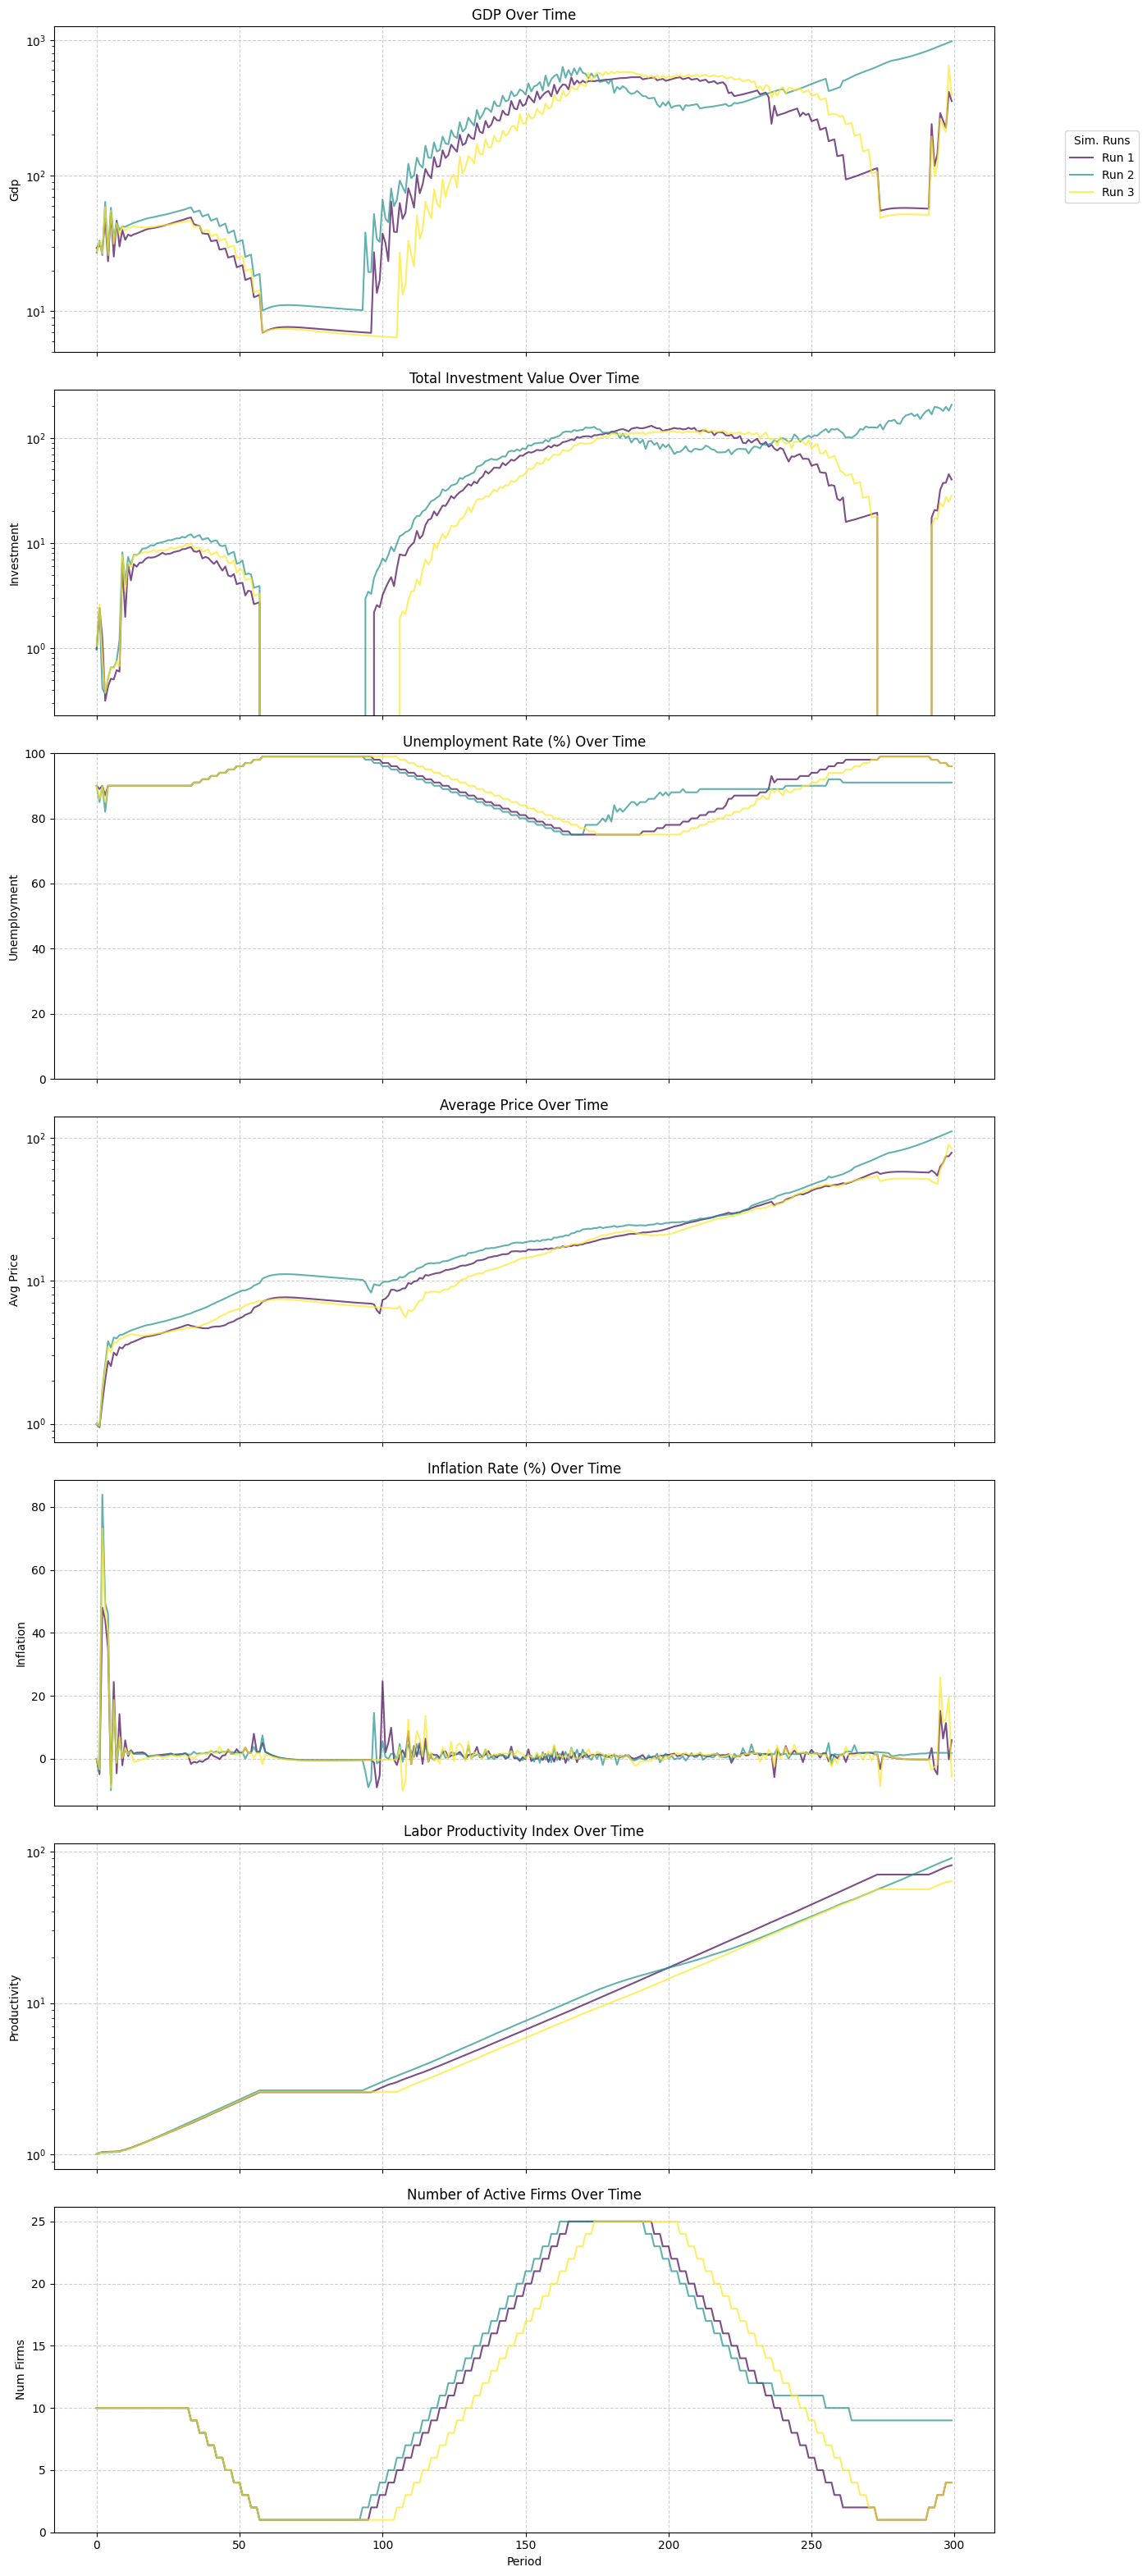


--- Сводная Таблица Результатов Запусков ---
   Run ID  Final Period     Max GDP  Avg GDP (Last 50)  Final Investment  Avg Investment (Last 50)  Final Unemployment (%)  Final Productivity (Avg)  Final Firms
0       1           300  533.677275         134.322099         40.228636                 19.066305                    96.0                 81.102728            4
1       2           300  978.442647         664.804016        207.411710                140.978217                    91.0                 90.534494            9
2       3           300  651.117788         182.989532         28.303476                 27.584647                    96.0                 63.630694            4


In [13]:
# multiple_runs_same_params.py
import mandel_test as abm_model # Ваш модуль с моделью
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Для сводной таблицы результатов

def run_and_collect_histories(simulation_params, run_id):
    """
    Запускает одну симуляцию и возвращает ее истории.
    """
    print(f"--- Запуск симуляции #{run_id} ---")
    
    # Для полной идентичности стохастичности между запусками с одинаковыми параметрами,
    # но разными run_id, лучше не переустанавливать seed здесь каждый раз,
    # а установить один раз в начале main, если это нужно.
    # Если нужна разная стохастичность для каждого run_id, то ничего не делаем с seed.
    # random.seed(42 + run_id) 
    # np.random.seed(42 + run_id)

    sim_instance = abm_model.Simulation(
        num_goods=simulation_params.get('num_goods', 1),
        num_households=simulation_params.get('num_households', 100),
        num_firms_per_sector_list=simulation_params.get('num_firms_initial_list', [20]),
        num_sectors=simulation_params.get('num_sectors', 1)
    )

    sim_instance.max_periods = simulation_params.get('max_periods', 300)
    sim_instance.genetic_evolution_periodicity = simulation_params.get('genetic_periodicity', 7)
    sim_instance.firm_management_periodicity = simulation_params.get('management_periodicity', 7)
    
    firm_exp_rate = simulation_params.get('firm_exp_rate', 0.1)
    price_smooth = simulation_params.get('price_smooth', 0.15)
    inv_shortfall_frac = simulation_params.get('inv_shortfall_frac', 0.75) # Этот параметр, кажется, не используется в Firm
    
    for firm_agent in sim_instance.firms:
        firm_agent.expected_sales_update_rate = firm_exp_rate
        firm_agent.price_update_smoothing = price_smooth
        # firm_agent.investment_capital_shortfall_fraction = inv_shortfall_frac # Проверьте, используется ли этот параметр

    hh_exp_rate = simulation_params.get('hh_exp_rate', 0.1)
    for hh_agent in sim_instance.households:
        hh_agent.expected_income_update_rate = hh_exp_rate

    sim_instance.run_simulation(plot_results=False)
    
    return {
        'run_id': run_id,
        'gdp': sim_instance.history_gdp,
        'investment': sim_instance.history_total_investment_value,
        'unemployment': sim_instance.history_unemployment_rate,
        'avg_price': sim_instance.history_avg_price,
        'inflation': sim_instance.history_inflation,
        'productivity': sim_instance.history_sector_productivity, # Это может быть list of lists
        'num_firms': sim_instance.history_num_firms,      # Это list of numbers (total firms)
        'final_period': sim_instance.current_period,
        'num_sectors_in_run': sim_instance.num_sectors # Добавим для удобства в plot
    }

def plot_multiple_run_histories(results_list, num_runs):
    """
    Рисует траектории из нескольких запусков на общих графиках.
    """
    if not results_list:
        print("Нет данных для построения графиков.")
        return

    max_len = 0
    for res in results_list:
        max_len = max(max_len, len(res['gdp'])) # Используем GDP для определения макс. длины
        if max_len == 0 and res.get('final_period', 0) > 0 : # Если GDP пустой, но симуляция шла
             max_len = res['final_period']


    periods = range(max_len)
    colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

    history_keys_titles = {
        'gdp': 'GDP Over Time',
        'investment': 'Total Investment Value Over Time',
        'unemployment': 'Unemployment Rate (%) Over Time',
        'avg_price': 'Average Price Over Time',
        'inflation': 'Inflation Rate (%) Over Time',
        'productivity': 'Labor Productivity Index Over Time',
        'num_firms': 'Number of Active Firms Over Time'
    }
    
    num_plots = len(history_keys_titles)
    fig, axs = plt.subplots(num_plots, 1, figsize=(14, num_plots * 4.5), sharex=True)

    plot_handles_labels_for_legend = {}

    for i, (key, title) in enumerate(history_keys_titles.items()):
        ax = axs[i]
        for run_idx, result_data in enumerate(results_list):
            history = result_data.get(key, [])
            
            current_run_label_base = f'Run {result_data["run_id"]}'

            if key == 'productivity':
                num_sectors_in_this_run = result_data.get('num_sectors_in_run', 1)
                if num_sectors_in_this_run > 1 and history and isinstance(history[0], list):
                    # Многосекторная производительность: history это list of lists like [[s1_t0, s2_t0], [s1_t1, s2_t1], ...]
                    for sector_j in range(num_sectors_in_this_run):
                        # Извлекаем данные для конкретного сектора j
                        sector_history_data = []
                        for period_data_all_sectors in history:
                            if period_data_all_sectors and len(period_data_all_sectors) > sector_j:
                                sector_history_data.append(period_data_all_sectors[sector_j])
                            else:
                                sector_history_data.append(np.nan) # Если данных нет для этого периода/сектора
                        
                        plot_data_sector = sector_history_data + [np.nan] * (max_len - len(sector_history_data))
                        
                        # Стиль линии может варьироваться для секторов одного запуска
                        linestyles = ['-', '--', ':', '-.']
                        linestyle = linestyles[sector_j % len(linestyles)]
                        
                        line, = ax.plot(periods, plot_data_sector, color=colors[run_idx % len(colors)], linestyle=linestyle,
                                label=f'{current_run_label_base} Sec {sector_j + 1}', alpha=0.65, linewidth=1.2)
                        if run_idx == 0 : # Собираем хэндлы только для первого запуска для чистоты легенды секторов
                            plot_handles_labels_for_legend[f'Sec {sector_j+1} (style {linestyle})'] = line

                else: # Односекторная производительность или уже агрегированные данные
                    plot_data = history + [np.nan] * (max_len - len(history))
                    line, = ax.plot(periods, plot_data, color=colors[run_idx % len(colors)], label=current_run_label_base, alpha=0.7, linewidth=1.5)
                    if current_run_label_base not in plot_handles_labels_for_legend:
                         plot_handles_labels_for_legend[current_run_label_base] = line

            else: # Для всех других ключей (GDP, num_firms и т.д.)
                plot_data = history + [np.nan] * (max_len - len(history))
                
                if key in ['unemployment', 'inflation']:
                    plot_data = [x * 100 if x is not None and isinstance(x, (float, int)) else np.nan for x in plot_data]

                line, = ax.plot(periods, plot_data, color=colors[run_idx % len(colors)], label=current_run_label_base, alpha=0.7, linewidth=1.5)
                if current_run_label_base not in plot_handles_labels_for_legend:
                    plot_handles_labels_for_legend[current_run_label_base] = line

        ax.set_title(title)
        ax.set_ylabel(key.replace('_', ' ').title())
        ax.grid(True, linestyle='--', alpha=0.6)
        if i == num_plots - 1: 
            ax.set_xlabel('Period')
        
        if key in ['gdp', 'investment', 'avg_price', 'productivity']:
            all_positive_values_for_key = []
            for res_data_log_scale in results_list:
                data_series_log = res_data_log_scale.get(key, [])
                if not data_series_log: continue

                if key == 'productivity' and res_data_log_scale.get('num_sectors_in_run',1) > 1 and isinstance(data_series_log[0], list):
                    for period_val_list in data_series_log:
                        if period_val_list:
                            all_positive_values_for_key.extend([val for val in period_val_list if val is not None and val > 1e-3])
                else:
                     all_positive_values_for_key.extend([val for val in data_series_log if val is not None and val > 1e-3])
            
            if all_positive_values_for_key and max(all_positive_values_for_key, default=0) > 10 and min(all_positive_values_for_key, default=1e-3) > 0:
                try:
                    ax.set_yscale('log')
                except ValueError: 
                    ax.set_yscale('linear')
            else:
                ax.set_yscale('linear')

        if key == 'unemployment':
            ax.set_ylim(0, 100)
        if key == 'num_firms':
            ax.set_ylim(bottom=0) # Число фирм не может быть отрицательным

    # Создаем общую легенду для запусков (Run ID)
    # Легенда для секторов (если есть) будет на самом графике productivity
    # или можно усложнить и собрать ее отдельно.
    # Пока ограничимся легендой для запусков.
    
    # Собираем уникальные хэндлы и метки для Runs
    unique_run_handles = []
    unique_run_labels = []
    for run_idx in range(num_runs):
        label = f'Run {results_list[run_idx]["run_id"]}'
        # Создаем "фиктивный" хэндл для легенды, если реальный не был сохранен или сложен
        # (например, если у какого-то запуска не было данных для первого графика)
        # Лучше брать хэндлы с первого графика, если они там есть для всех запусков
        try:
            first_ax_lines = axs[0].get_lines()
            handle_found = False
            for line in first_ax_lines:
                if line.get_label() == label:
                    if label not in unique_run_labels:
                        unique_run_handles.append(line)
                        unique_run_labels.append(label)
                        handle_found = True
                    break
            if not handle_found and label not in unique_run_labels: # Если для какого-то run_id не нашлось линии на первом графике
                # Создаем proxy artist для легенды
                proxy_line = plt.Line2D([0], [0], linestyle='-', color=colors[run_idx % len(colors)], linewidth=1.5)
                unique_run_handles.append(proxy_line)
                unique_run_labels.append(label)

        except IndexError: # Если axs[0] не существует (например, num_plots=0)
            pass


    if unique_run_handles:
         fig.legend(unique_run_handles, unique_run_labels, loc='upper right', bbox_to_anchor=(1.0, 0.95), title="Sim. Runs")

    plt.tight_layout(rect=[0, 0, 0.88, 1]) # Оставляем место для легенды справа, если она длинная
    plt.show()

def summarize_results(results_list):
    """
    Создает сводную таблицу с ключевыми метриками по итогам запусков.
    """
    summary_data = []
    for res in results_list:
        
        # Обработка производительности для сводки (например, среднее по секторам на последнем шаге)
        final_productivity_value = -1
        if res['productivity']:
            last_prod_data = res['productivity'][-1]
            if isinstance(last_prod_data, list): # Многосекторный
                valid_sector_prods = [p for p in last_prod_data if p is not None]
                if valid_sector_prods:
                    final_productivity_value = np.mean(valid_sector_prods)
                else:
                    final_productivity_value = -1 # или np.nan
            else: # Односекторный
                final_productivity_value = last_prod_data if last_prod_data is not None else -1
        
        gdp_series = [g for g in res['gdp'] if g is not None]
        inv_series = [i for i in res['investment'] if i is not None]
        unemp_series = [u for u in res['unemployment'] if u is not None]
        n_firms_series = [nf for nf in res['num_firms'] if nf is not None]

        summary_data.append({
            'Run ID': res['run_id'],
            'Final Period': res['final_period'],
            'Max GDP': np.max(gdp_series) if gdp_series else 0,
            'Avg GDP (Last 50)': np.mean(gdp_series[-50:]) if len(gdp_series) >= 50 else (np.mean(gdp_series) if gdp_series else 0),
            'Final Investment': inv_series[-1] if inv_series else 0,
            'Avg Investment (Last 50)': np.mean(inv_series[-50:]) if len(inv_series) >= 50 else (np.mean(inv_series) if inv_series else 0),
            'Final Unemployment (%)': unemp_series[-1]*100 if unemp_series else -1,
            'Final Productivity (Avg)': final_productivity_value,
            'Final Firms': n_firms_series[-1] if n_firms_series else 0
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n--- Сводная Таблица Результатов Запусков ---")
    print(df_summary.to_string()) # .to_string() для лучшего вывода в консоль
    return df_summary

if __name__ == "__main__":
    NUMBER_OF_RUNS = 3 # Сколько раз запустить симуляцию

    # --- Параметры симуляции, ОДИНАКОВЫЕ для всех запусков ---
    simulation_parameters = {
        'max_periods': 300, # Уменьшил для быстрого теста
        'num_households': 100, # Уменьшил для быстрого теста
        'num_firms_initial_list': [10], # Многосекторный пример
        'num_sectors': 1,                 # Многосекторный пример
        'num_goods': 1,                   # Многосекторный пример
        'genetic_periodicity': 5,
        'management_periodicity': 3,
        'firm_exp_rate': 0.1, 
        'price_smooth': 0.2,
        'hh_exp_rate': 0.1,
    }
    # Убрал ошибочный ключ '':,

    all_run_results = []
    for i in range(NUMBER_OF_RUNS):
        result = run_and_collect_histories(simulation_parameters, run_id=i + 1)
        all_run_results.append(result)

    plot_multiple_run_histories(all_run_results, NUMBER_OF_RUNS)
    
    summary_df = summarize_results(all_run_results)
    # summary_df.to_csv("multiple_runs_summary.csv", index=False)